# Mammogram mass: benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Goal

The goal is to find the ML method that achieves the highest accuracy in predicting whether a mass is benign or malignant.

To achieve this, a few steps were followed:
1. Exploratory Data Analysis
2. Data Pre-processing
3. Apply different supervised machine learning methods

The methods include:
* Decision Tree
* Random Forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* Neural Network

## Import libraries and load data

In [202]:
%pip install pydotplus
%pip install xgboost
%pip install joblib


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [204]:
import pandas as pd
import numpy as np
import seaborn as sns           
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

from IPython.display import Image  
from six import StringIO  
import pydotplus

from joblib import dump

In [209]:
masses_data = pd.read_csv('data/mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
masses_data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


## 1. Exploratory Data Analysis (EDA)


### 1.1 High-level Description

The `masses_data` dataset comprises 961 entries and 6 columns. While the dataset contains 961 entries, not all columns are fully populated:

- **BI-RADS**: 959 non-null entries
- **age**: 956 non-null entries
- **shape**: 930 non-null entries
- **margin**: 913 non-null entries
- **density**: 885 non-null entries 

The target variable, `severity`, however, is complete with 961 entries.

Statistical insights reveal that the average age of patients in the dataset is approximately 55.5 years. For categorical variables such as `shape`, `margin`, `density`, and `BI-RADS`, the mode provides more meaningful insights:

- **BI-RADS**: Mode = 4.0
- **shape**: Mode = 4.0
- **margin**: Mode = 1.0
- **density**: Mode = 3.0

From the data, the mean of the `severity` column is approximately 0.463, highlighting that the dataset is fairly balanced in terms of benign (0) and malignant (1) classifications.

From a datatype perspective, five columns hold `float64` type data while `severity` (target) contains `int64` values. This dataset presents a mix of continuous and categorical data, with certain missing entries that might require preprocessing before analysis or modeling.


In [144]:
masses_data.shape

(961, 6)

In [145]:
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [146]:
masses_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   959 non-null    float64
 1   age       956 non-null    float64
 2   shape     930 non-null    float64
 3   margin    913 non-null    float64
 4   density   885 non-null    float64
 5   severity  961 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.2 KB


In [147]:
masses_data.dtypes

BI-RADS     float64
age         float64
shape       float64
margin      float64
density     float64
severity      int64
dtype: object

In [148]:
# Get the mode for each variable
masses_data.mode().iloc[0]

BI-RADS      4.0
age         59.0
shape        4.0
margin       1.0
density      3.0
severity     0.0
Name: 0, dtype: float64

### 1.2 Drop irrelevant columns
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.


In [149]:
masses_data = masses_data.drop(['BI-RADS'], axis=1)
masses_data.head(5)

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
1,43.0,1.0,1.0,NaN,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
4,74.0,1.0,5.0,NaN,1


### 1.3 Missing Values

The dataset has missing values in several columns, most notably in density (7.9%), followed by margin, shape, and age. There are no missing values in the severity column. We identified 130 rows with at least one missing value, some of which had more than one missing attribute. Prior to handling these, the severity distribution was 53.69% benign (0) and 46.31% malignant (1). After deciding to eliminate these rows, we were left with 831 records. Importantly, this action improved the balance of the dataset to 51.50% benign and 48.50% malignant.

In [150]:
# Number of MV per feature
masses_data.isnull().sum()

age          5
shape       31
margin      48
density     76
severity     0
dtype: int64

In [151]:
# Percentage of MV per feature
(masses_data.isnull().sum()/(len(masses_data)))*100

age         0.520291
shape       3.225806
margin      4.994797
density     7.908429
severity    0.000000
dtype: float64

In [152]:
# Check the rows with a least one missing value
masses_data[masses_data.isnull().any(axis=1)]

,age,shape,margin,density,severity
1,43.0,1.0,1.0,NaN,1
4,74.0,1.0,5.0,NaN,1
5,65.0,1.0,NaN,3.0,0
6,70.0,NaN,NaN,3.0,0
7,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...
778,60.0,NaN,4.0,3.0,0
819,35.0,3.0,NaN,2.0,0
824,40.0,NaN,3.0,4.0,1
884,NaN,4.0,4.0,3.0,1


In [153]:
# Check how balanced the dataset is
((masses_data['severity'].value_counts()) / len(masses_data)) * 100

0    53.694069
1    46.305931
Name: severity, dtype: float64

In [154]:
# Drop the rows with missing values
masses_data = masses_data.dropna()
masses_data

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
8,57.0,1.0,5.0,3.0,1
10,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
956,47.0,2.0,1.0,3.0,0
957,56.0,4.0,5.0,3.0,1
958,64.0,4.0,5.0,3.0,0
959,66.0,4.0,5.0,3.0,1


In [155]:
# Check how dropping the rows with MV affected the balance of the dataset
masses_data['severity'].value_counts()
((masses_data['severity'].value_counts()) / len(masses_data)) * 100

0    51.504212
1    48.495788
Name: severity, dtype: float64

### 1.4 Univariate Analysis

When analyzing continuous variables like 'Age', we utilize visualization tools such as histograms and box plots to get an insightful view of the distribution and spread. For categorical variables like 'Shape', 'Margin', and 'Density', count plots are employed to offer a clear representation of the frequency distribution.

Upon examining the visualizations, several key observations emerge:

- Outliers: There aren't any noticeable outliers across the features, signifying the cleanliness of the dataset in terms of anomalies.
- Age: The data indicates that ages range between 18 and 96, which fits within a logical and expected range.
- Categorical Variables: Every value observed for these variables resides comfortably within their domain.
- Target Variable (Severity): This specific variable holds only binary values, thus confirming its integrity.

Concluding our analysis, the data appears to be in good shape, especially concerning outliers, suggesting there's no immediate need for outlier-specific data processing.

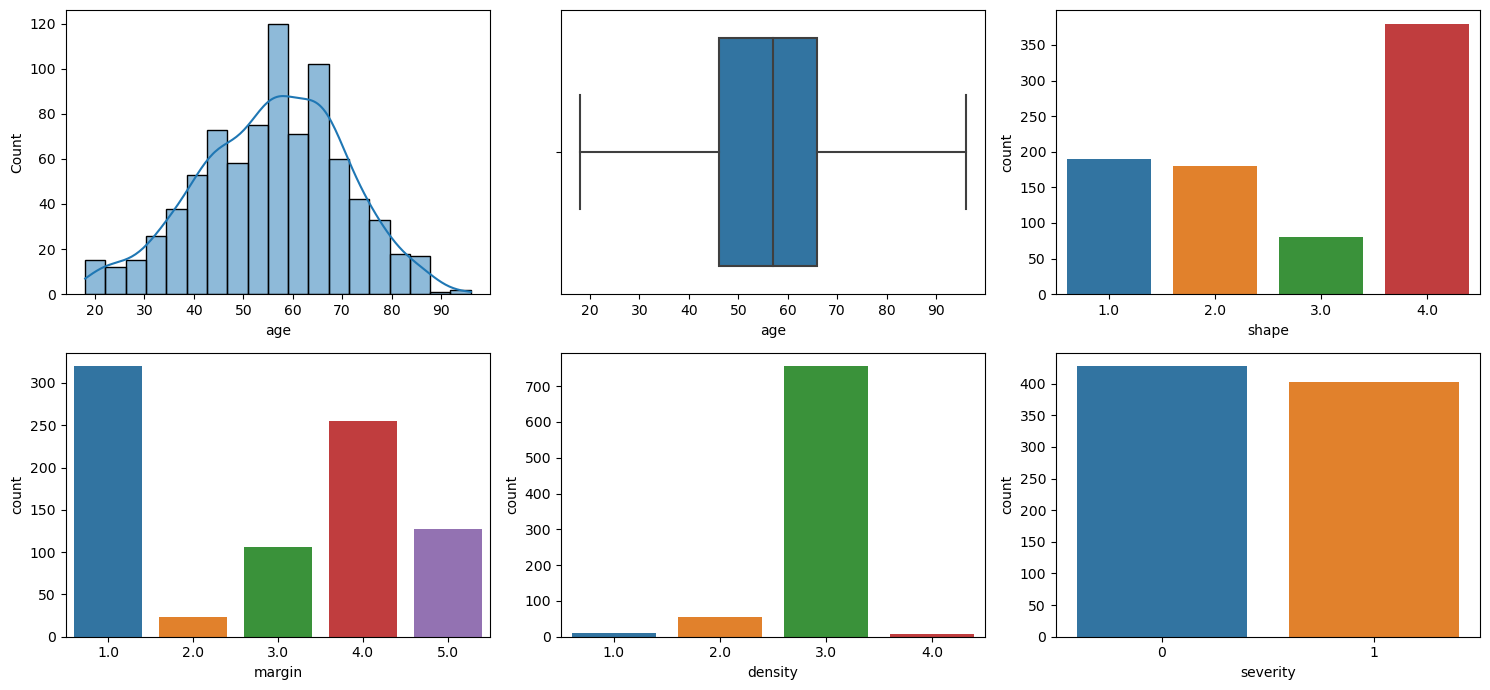

In [156]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 3, 1)
sns.histplot(masses_data['age'], kde=True)

plt.subplot(2, 3, 2)
sns.boxplot(x='age', data=masses_data)

plt.subplot(2, 3, 3)
sns.countplot(x='shape', data=masses_data)

plt.subplot(2, 3, 4)
sns.countplot(x='margin', data=masses_data)

plt.subplot(2, 3, 5)
sns.countplot(x='density', data=masses_data)

plt.subplot(2, 3, 6)
sns.countplot(x='severity', data=masses_data)

plt.tight_layout()

plt.show()

### 1.4 Multivariate Analysis

#### 1.4.1 Correlation 
Shape and margin have the highest correlation (0.74) and they are also the ones with the highest correlation with the target variable, followed by age. This suggests they will have an import role in predicting whether the mass is malignant or benign.

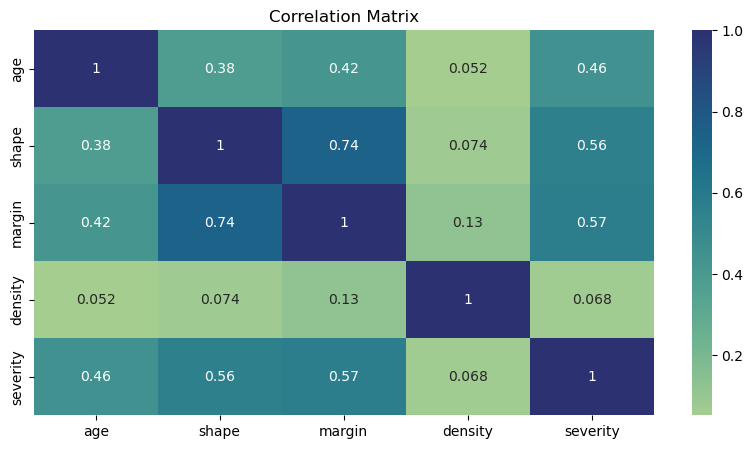

In [157]:
plt.figure(figsize=(10,5))
c= masses_data.corr()
sns.heatmap(c,cmap="crest",annot=True)
plt.title("Correlation Matrix")
plt.show()

#### 1.4.2 Relationship with the Target Variable

A discernible trend is that individuals with malignant masses tend to be older. Moreover, when examining the features of `shape` and `margin`, we find that benign masses are often characterized by lower values, while malignant masses typically exhibit higher values. This implies that elevated values in these features could be strong indicators of malignancy. Conversely, the `density` feature appears to have a negligible influence on the severity prediction, given the consistent outcomes across its different values.

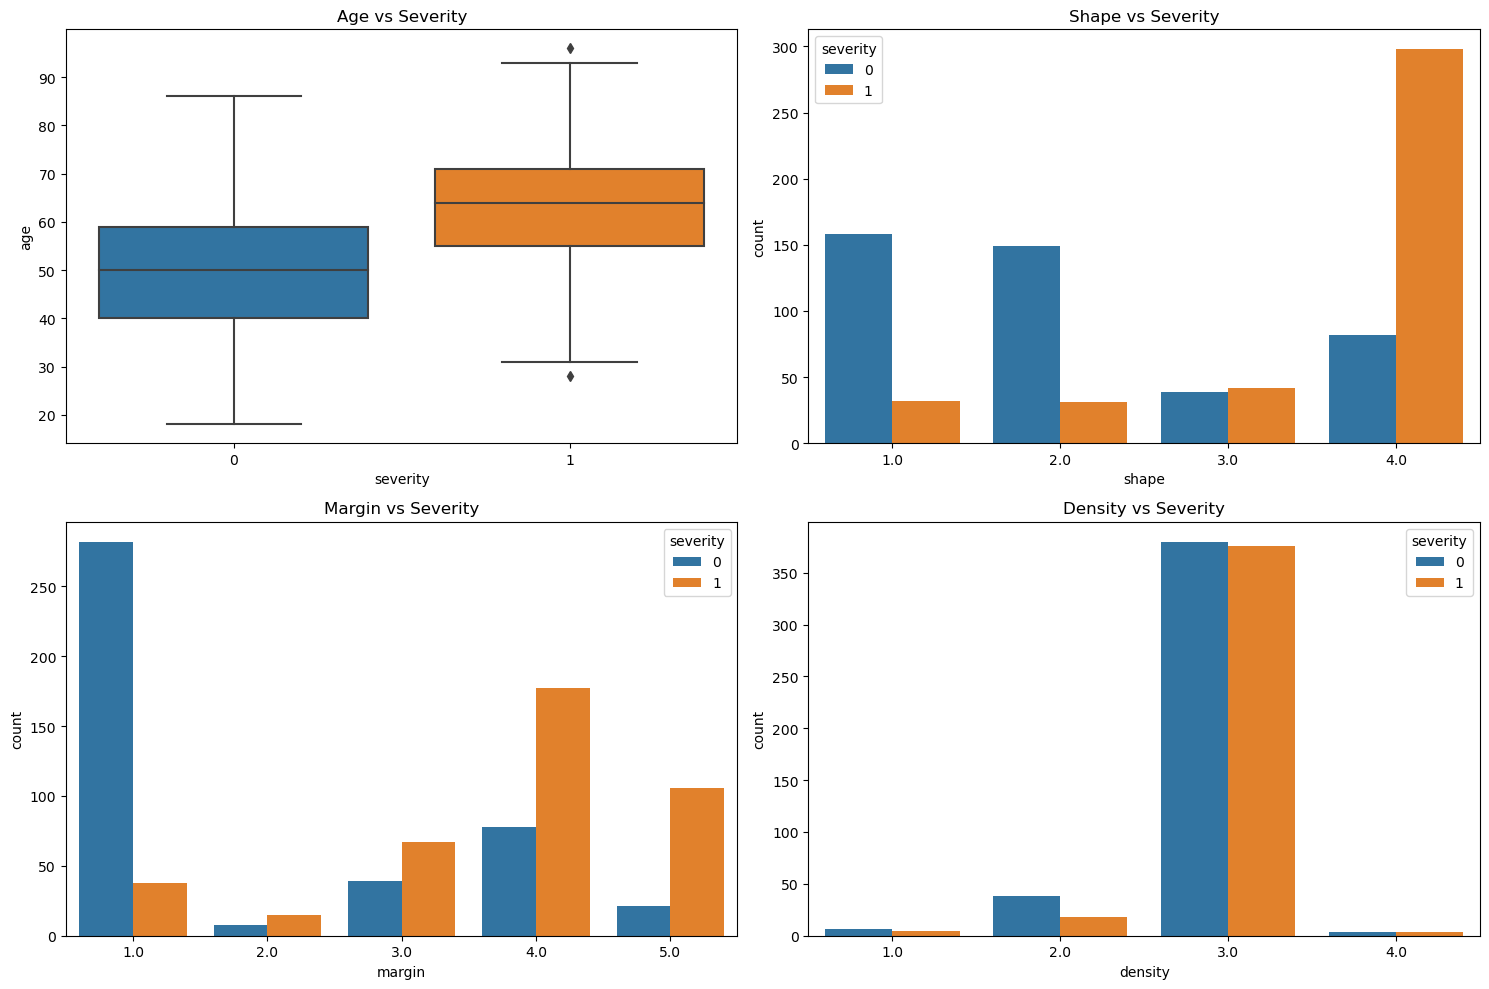

In [158]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=masses_data, x="severity", y="age")
plt.title("Age vs Severity")

plt.subplot(2, 2, 2)
sns.countplot(data=masses_data, x="shape", hue="severity")
plt.title("Shape vs Severity")

plt.subplot(2, 2, 3)
sns.countplot(data=masses_data, x="margin", hue="severity")
plt.title("Margin vs Severity")

plt.subplot(2, 2, 4)
sns.countplot(data=masses_data, x="density", hue="severity")
plt.title("Density vs Severity")

plt.tight_layout()

plt.show()

### 1.5 Conclusions
- 130 rows were removed due to missing values
- The `BI-RADS` column was removed
- No outliers
- `shape`, `margin` and `age` look like the most relevant predictors of severity
- 831 instances, 4 features, 1 target. 

In [159]:
masses_data

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
8,57.0,1.0,5.0,3.0,1
10,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
956,47.0,2.0,1.0,3.0,0
957,56.0,4.0,5.0,3.0,1
958,64.0,4.0,5.0,3.0,0
959,66.0,4.0,5.0,3.0,1


## 2. Pre-Processing

### 2.1 Scaling/Normalization
Feature scaling ensures all input features have the same scale or range. In the context of this project, scaling plays a pivotal role for certain algorithms.

- **SVM & Neural Networks**: Scaled features drive a smoother and faster optimization process.
- **kNN**: Being a distance-based algorithm, scaling ensures that no feature overshadows others because of its range.
- **Logistic Regression**: when regularization is applied, scaling can be beneficial.

On the flip side, some models are relatively indifferent to feature scaling:
- **Tree-Based Models**: Algorithms like *Decision Trees*, *Random Forests*, and *XGBoost* prioritize feature importance over absolute scale.
- **Naive Bayes**: Its probabilistic nature tends to be less swayed by the scale of input features.

Lastly, if a feature's magnitude is meaningful and essential for interpretability, scaling might warrant a second thought.

In [160]:
X = masses_data.drop('severity', axis=1)
y = masses_data['severity']

In [161]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaler = MinMaxScaler()
X_scaled_min_max = scaler.fit_transform(X)

### 2.2 Split Dataset
The dataset is split with 80% for training and 20% for testing. As the dataset is balanced, there is no need for deliberate stratification.

In [162]:
# The normal dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The dataset scaled with Standard Scaler
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# The dataset scaled with Min Max Scaler
X_train_scaled_min_max, X_test_scaled_min_max, y_train, y_test = train_test_split(X_scaled_min_max, y, test_size=0.2, random_state=42)

## 3. Model Building, Optimization and Evaluation

In this section, we'll dive into building, tweaking, and testing different predictive models. We're using a variety of machine learning algorithms to see which one can best predict whether a mammogram mass is benign or malignant. Our process is straightforward: build a initial model with the full training data and then do hyperparameter tuning. Our goal is simple: find the model that gives us the most accurate results. 

**Training:** The training will be done on 80% of the initial dataset. For the hyperparameter tuning, I'll do 5-fold cross validation and then pick the model with the best mean accuracy over the 5 splits. I'll then run this model on the testing set and check performance.
It will also be possible to visualize an histogram of the scores for different hyperparameters combinations.

**Performance:** We're using `accuracy` as our main metric for evaluation, which works well for our balanced dataset. 

**Feature Importance:** For some models, we'll check which features contribute the most for the classification.

### 3.1 Logistic Regression

#### 3.1.1 Initial Model Evaluation

In [163]:
# Initialize the classifier
clf = LogisticRegression(random_state=0)

# Fit the classifier with training data
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Accuracy on Test Data: 77.84%


#### 3.1.2 Hyperparameter Tuning

In [164]:
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']
}

pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

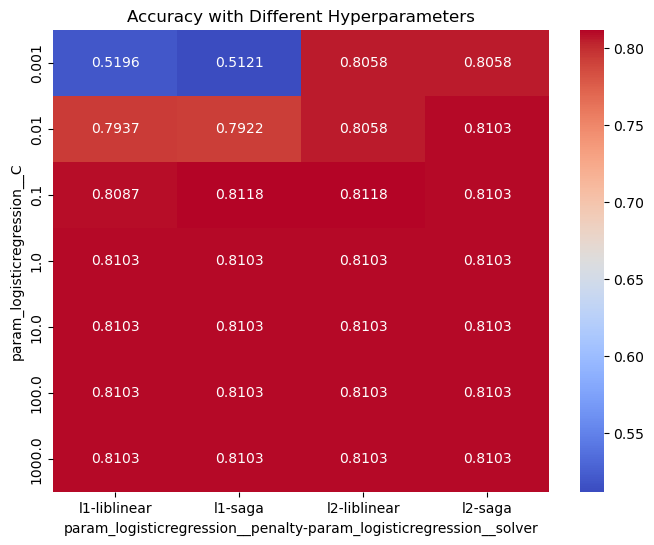

In [165]:
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot_table(
    index='param_logisticregression__C', 
    columns=['param_logisticregression__penalty', 'param_logisticregression__solver'], 
    values='mean_test_score',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="coolwarm", cbar=True)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [166]:
# Show the accuracy on training data and the best parameters
print("Best Parameters:", grid_search.best_params_)
print(f"\nAccuracy on Training Data: {100*grid_search.best_score_:.2f}%")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Best Parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}

Accuracy on Training Data: 81.18%
Accuracy on Test Data: 78.44%


#### 3.1.3 Analyse Feature Importance
The shape and age features were the most relevant, followed closely by the margin.

   Feature  Coefficient
1    shape     0.764369
0      age     0.710126
2   margin     0.591934
3  density     0.000000


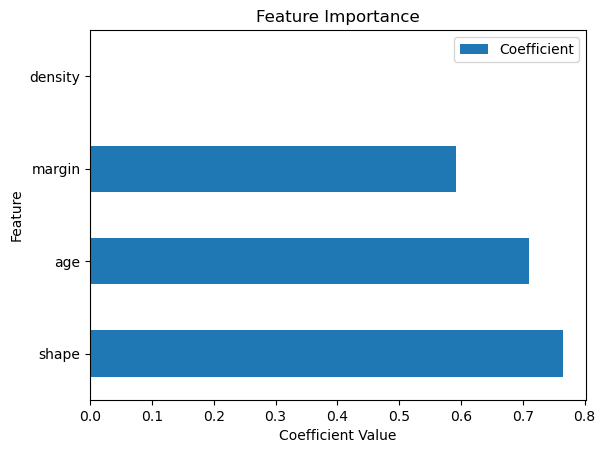

In [167]:
best_model = grid_search.best_estimator_

# Extract the logistic regression model from the best model
lr = best_model.named_steps['logisticregression']

# Get the feature names (assuming X_train is a DataFrame)
feature_names = X_train.columns

# Get the coefficients from the logistic regression model
coefficients = lr.coef_[0]

# Combine feature names and coefficients into a dataframe
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the features by the absolute value of their coefficients
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(coef_df)

coef_df.plot(kind='barh', x='Feature', y='Coefficient')
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

#### 3.1.4 Save the model

In [207]:
dump(grid_search.best_estimator_, 'models/log_reg_model.joblib')

['models/log_reg_model.joblib']

### 3.2 Naive Bayes

#### 3.2.1 Build and Evaluate Model

In [168]:
# Initialize the classifier
clf = MultinomialNB()

# Fit the classifier with training data
clf.fit(X_train_scaled_min_max, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled_min_max)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {100*accuracy:.2f}%")

Accuracy on test set: 75.45%


In [169]:
clf.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

#### 3.2.2 Hyperparameter Tuning

In [220]:
# Define the parameter grid to search
param_grid = {'multinomialnb__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0]}

# Create the pipeline
pipeline = make_pipeline(MinMaxScaler(), MultinomialNB())  # Increased max_iter for convergence

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5,
                                                  1.0, 10.0]},
             scoring='accuracy', verbose=1)

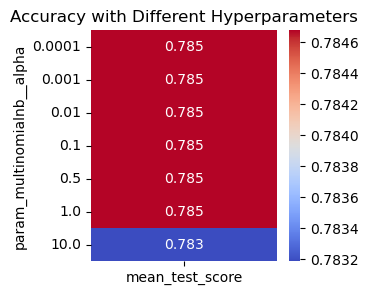

In [221]:
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot_table(
    index='param_multinomialnb__alpha', 
    values='mean_test_score',
    aggfunc='mean'
)

plt.figure(figsize=(3, 3))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [222]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Score: {100*grid_search.best_score_:.2f}%")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Best Parameters: {'multinomialnb__alpha': 0.0001}
Best Cross-Validation Score: 78.47%
Accuracy on Test Data: 75.45%


#### 3.2.3 Save the model

In [223]:
dump(grid_search.best_estimator_, 'models/nb_model.joblib')

['models/nb_model.joblib']

### 3.3 kNN

#### 3.3.1 Build Initial Model

In [173]:
# Initialize the classifier
clf = KNeighborsClassifier(n_neighbors=10)

# Fit the classifier with training data
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Accuracy on Test Data: 74.25%


#### 3.3.2 Hyperparameter Tuning

In [215]:
# Define the parameter grid to search
param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1,20)),
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=1)

# Fit the model (assuming you have data prepared in X_train and y_train)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan',
                                                          'chebyshev',
                                                          'minkowski'],
                         'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14, 15,
                                                               16, 17, 18,
                                                               19]},
             scoring='accuracy', verbose=1)

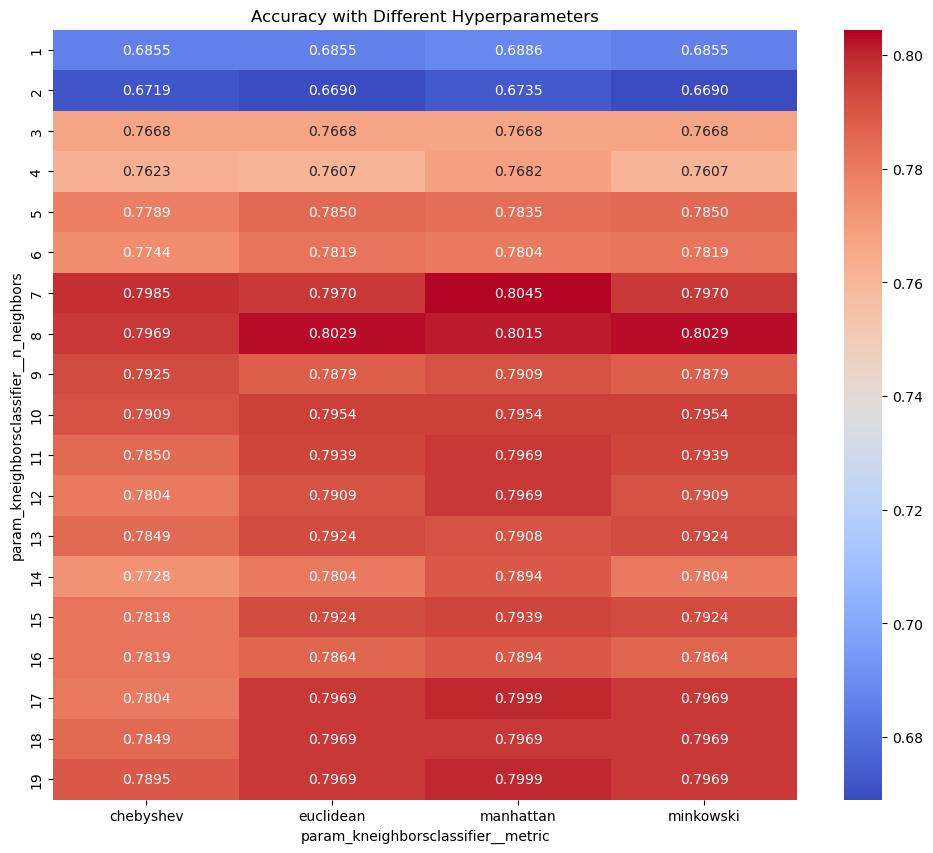

In [216]:
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot_table(
    index='param_kneighborsclassifier__n_neighbors', 
    columns=['param_kneighborsclassifier__metric'], 
    values='mean_test_score',
    aggfunc='mean'
)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="coolwarm", cbar=True)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [217]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Score on Train data: {100*grid_search.best_score_:.2f}%")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Best Parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 7}
Best CV Score on Train data: 80.45%
Accuracy on Test Data: 75.45%


#### 3.3.3 Save the model

In [219]:
dump(grid_search.best_estimator_, 'models/knn_model.joblib')

['models/knn_model.joblib']

### 3.4 Decision Trees

#### 3.4.1 Build Initial Model

In [177]:
# Initialize the classifier
clf = DecisionTreeClassifier(max_depth=3)

# Fit the classifier with training data
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Accuracy on Test Data: 75.45%


We set the max_depth to 3 as it provided the best performance on the test data and also allowed a good visualization of the tree structure.

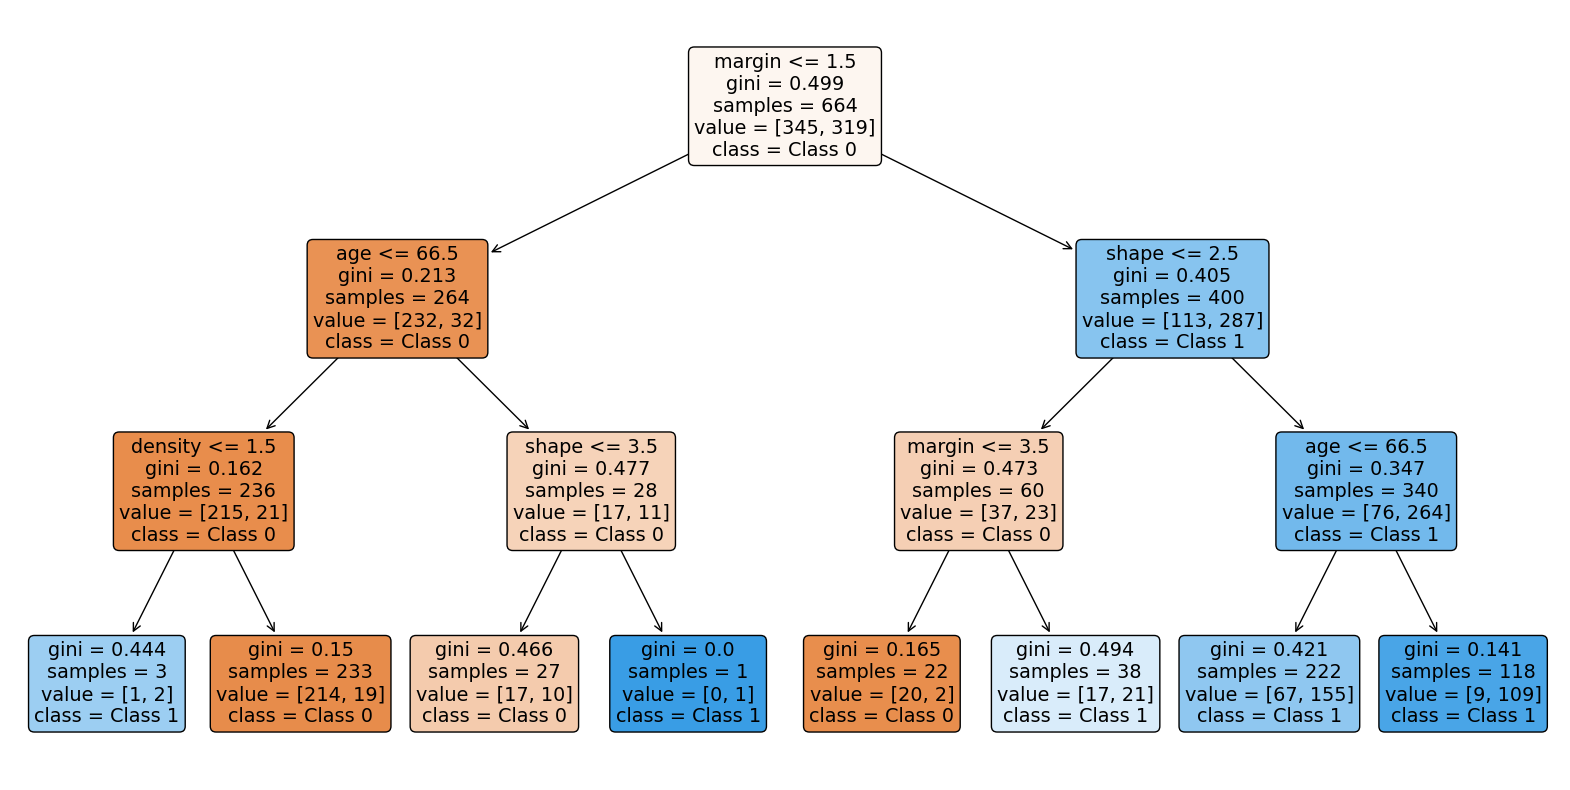

In [178]:
# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns.tolist(), class_names=["Class 0", "Class 1"], rounded=True)
plt.show()

#### 3.4.2 Hyperparameter Tuning

In [225]:
# Define the parameter grid to search
param_grid = {
    'decisiontreeclassifier__max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__criterion': ["gini", "entropy"]
}

# Create a pipeline with a decision tree classifier
pipeline = make_pipeline(DecisionTreeClassifier(random_state=0))

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [None, 2, 3, 4, 5,
                                                               6, 7, 8, 9, 10,
                                                               15, 20],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
                         'decisiontreeclassifier__min_samples_split': [2, 5,
                                                                       10]},
             scoring='accuracy', verbose=1)

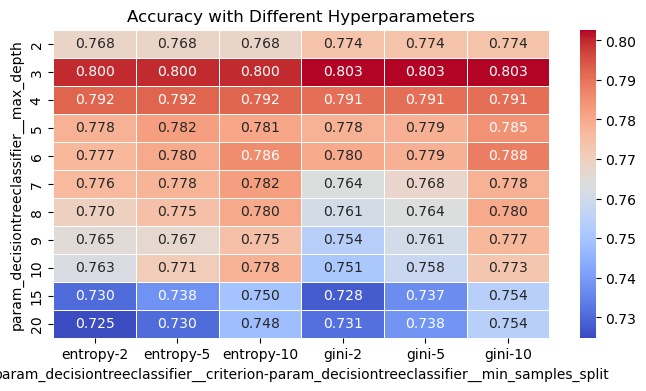

In [226]:
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot_table(
    index=['param_decisiontreeclassifier__max_depth'],
    columns=['param_decisiontreeclassifier__criterion', 'param_decisiontreeclassifier__min_samples_split'],
    values='mean_test_score'
)

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [227]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Score on Train data: {100*grid_search.best_score_:.2f}%")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Best Parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}
Best CV Score on Train data: 80.27%
Accuracy on Test Data: 75.45%


#### 3.4.3 Feature Importance

   Feature  Importance
2   margin    0.793286
1    shape    0.110157
0      age    0.083041
3  density    0.013516


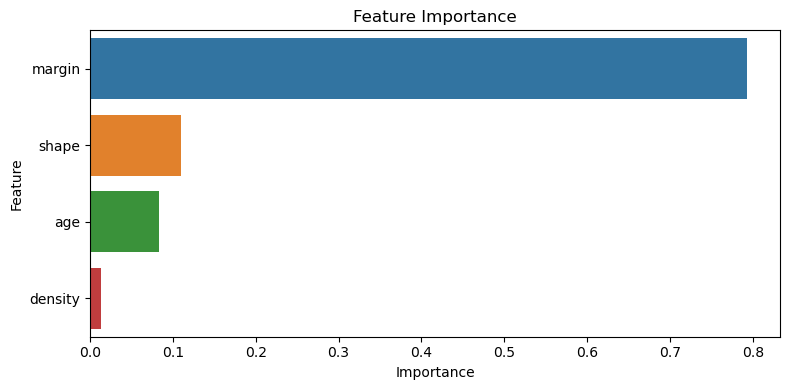

In [228]:
# Assuming you have a trained Decision Tree model from GridSearchCV
best_model = grid_search.best_estimator_

# Extract the decision tree model from the best model
dt = best_model.named_steps['decisiontreeclassifier']

# Get the feature importances
importances = dt.feature_importances_

# Assuming X_train is a DataFrame and you want to use the column names as feature names
feature_names = X_train.columns

# Combine feature names and importances into a dataframe and sort by importance
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(importances_df)

# Visualization
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### 3.4.4 Save the model

In [229]:
dump(grid_search.best_estimator_, 'models/dt_model.joblib')

['models/dt_model.joblib']

### 3.5 Ensemble Methods

#### 3.5.1 Random Forest

##### 3.5.1.1 Build Initial Model

In [183]:
# Initialize the classifier
clf = RandomForestClassifier(n_estimators=8)

# Fit the classifier with training data
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Accuracy on Test Data: 80.84%


##### 3.5.1.2 Hyperparameter Tuning

In [ ]:
# Define the parameter grid to search
param_grid = {
    'randomforestclassifier__n_estimators': [10, 50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
}

# Create a pipeline with a random forest classifier
pipeline = make_pipeline(RandomForestClassifier(random_state=0))

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

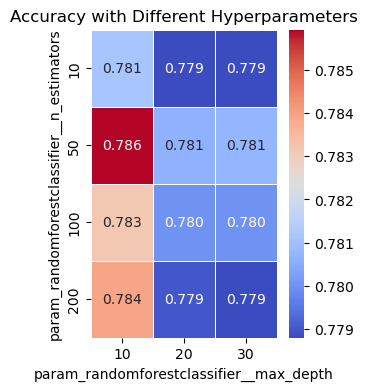

In [185]:
# Collect results in a DataFrame
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

# Here, creating a pivot table could be complex due to the high dimensionality of the hyperparameter space.
# We might consider plotting the most influential parameters or using a different visualization technique.
# For simplicity, we'll plot the relationship between 'n_estimators' and 'max_depth' for now.

pivot_table = results_df.pivot_table(
    index=['param_randomforestclassifier__n_estimators'],
    columns=['param_randomforestclassifier__max_depth'],
    values='mean_test_score'
)

# Plot the heatmap
plt.figure(figsize=(3, 4))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [186]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Score on Train data: {100*grid_search.best_score_:.2f}%")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Best Parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 10}
Best CV Score on Train data: 80.57%
Accuracy on Test Data: 79.64%


##### 3.5.1.3 Feature Importance
The importance of a feature if computed by measuring the decrease in impurity when a feature is used for splitting during the tree building phase.

   Feature  Importance
0      age    0.368076
1    shape    0.329927
2   margin    0.288766
3  density    0.013231


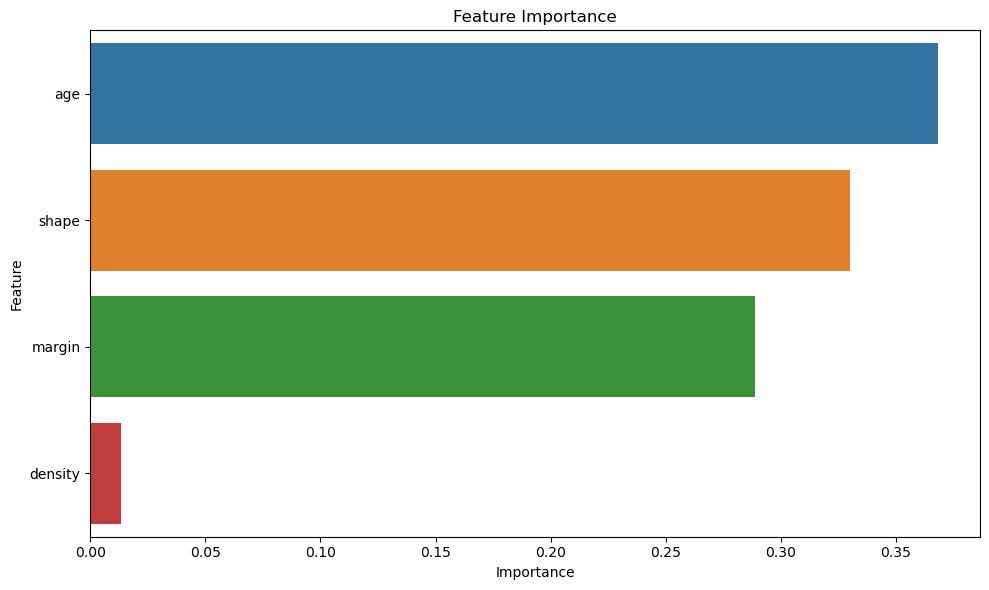

In [187]:
# Get best Random Forest model from GridSearchCV
best_model = grid_search.best_estimator_

# Extract the random forest model from the best model
rf = best_model.named_steps['randomforestclassifier']

# Get the feature importances
importances = rf.feature_importances_

feature_names = X_train.columns

# Combine feature names and importances into a dataframe and sort by importance
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(importances_df)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### 3.5.2. XGBoost

##### 3.5.2.1 Build and Evaluate Model

In [188]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 4,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': 3} 
epochs = 10 

model = xgb.train(param, train, epochs)
predictions = model.predict(test)

accuracy_score(y_test, predictions)

0.7964071856287425

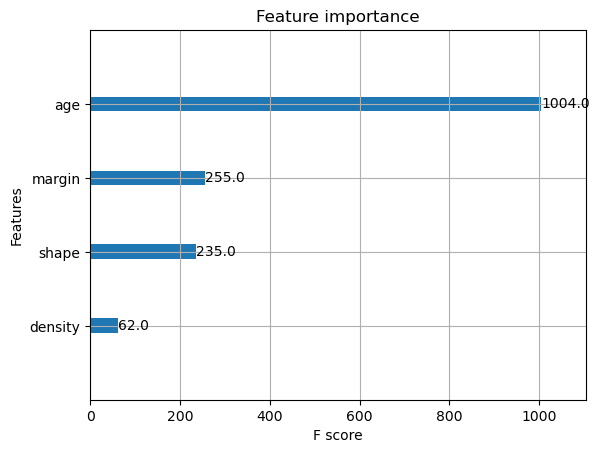

In [189]:
# Fit the model to the entire dataset
xgb_classifier.fit(X_train, y_train)

# Plot feature importances
xgb.plot_importance(xgb_classifier)
plt.show()

##### 3.5.2.2 Hyperparameter Tuning

In [ ]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid
param_grid = {
    'xgbclassifier__n_estimators': [50, 100, 500, 1000],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'xgbclassifier__max_depth': [3, 5, 7]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

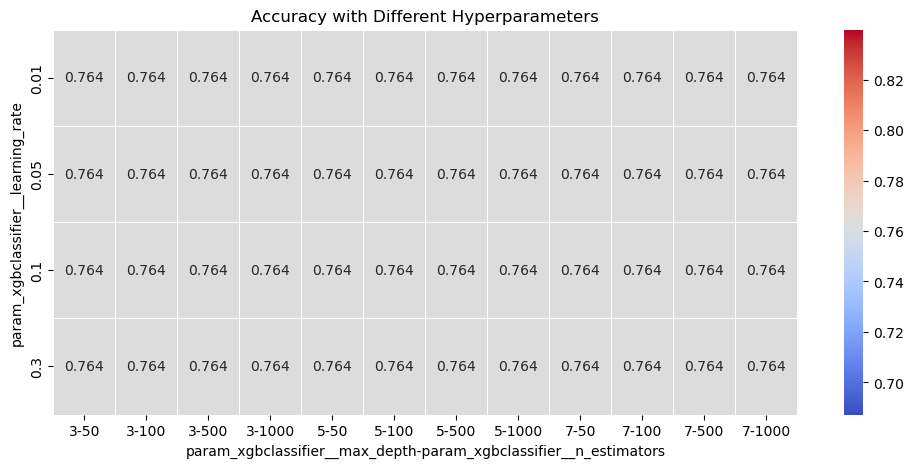

In [191]:
# Collect results in a DataFrame
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

# Here, creating a pivot table could be complex due to the high dimensionality of the hyperparameter space.
# We might consider plotting the most influential parameters or using a different visualization technique.
# For simplicity, we'll plot the relationship between 'n_estimators' and 'max_depth' for now.

pivot_table = results_df.pivot_table(
    index=['param_xgbclassifier__learning_rate'],
    columns=['param_xgbclassifier__max_depth', 'param_xgbclassifier__n_estimators'],
    values='mean_test_score'
)

# Plot the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [192]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Score on Train data: {100*grid_search.best_score_:.2f}%")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Best Parameters: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 50}
Best CV Score on Train data: 76.35%
Accuracy on Test Data: 79.64%


### 3.6 Support Vector Machines (SVM)

#### 3.6.1 Build Initial Model

In [193]:
# Initialize the classifier
clf = SVC()

# Fit the classifier with training data
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Accuracy on Test Data: 77.84%


#### 3.6.2 Hyperparameter Tuning

In [194]:
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['auto', 'scale', 0.1, 1, 10, 100]
}

pipeline = make_pipeline(StandardScaler(), SVC())

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__gamma': ['auto', 'scale', 0.1, 1, 10, 100],
                         'svc__kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

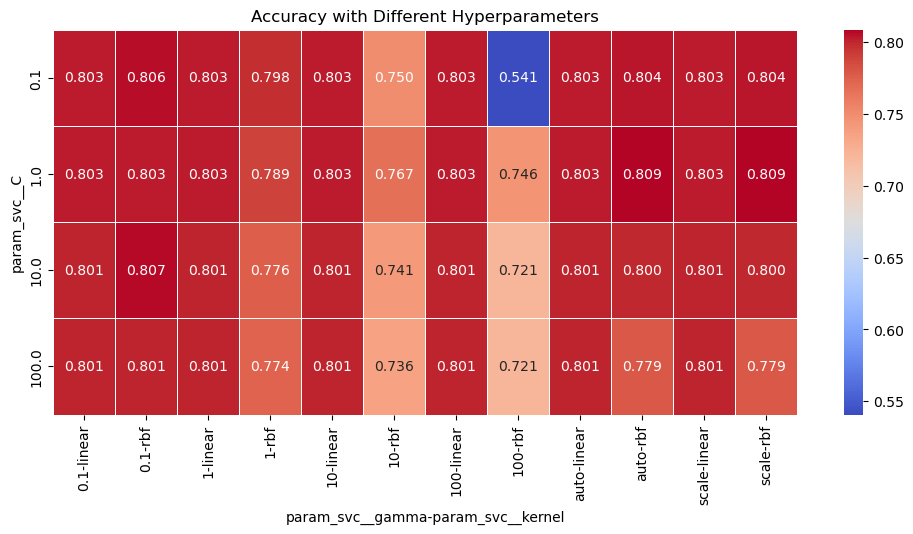

In [195]:
# Collect results in a DataFrame
results = grid_search.cv_results_
results_df = pd.DataFrame(results)

# Here, creating a pivot table could be complex due to the high dimensionality of the hyperparameter space.
# We might consider plotting the most influential parameters or using a different visualization technique.
# For simplicity, we'll plot the relationship between 'n_estimators' and 'max_depth' for now.

pivot_table = results_df.pivot_table(
    index=['param_svc__C'],
    columns=['param_svc__gamma', 'param_svc__kernel'],
    values='mean_test_score'
)

# Plot the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Accuracy with Different Hyperparameters')
plt.show()

In [196]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Score on Train data: {100*grid_search.best_score_:.2f}%")

# Calculate the accuracy for test dataset
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {100*accuracy:.2f}%")

Best Parameters: {'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Best CV Score on Train data: 80.88%
Accuracy on Test Data: 79.04%


### 3.7 Neural Networks

#### 3.7.1 Tensorflow

In [197]:
def create_model():
    model = Sequential()
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
estimator = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)

cv_scores = cross_val_score(estimator, X_scaled, y, cv=5)
cv_scores.mean()

#### 3.7.2 PyTorch

## 4. Conclusions


In this project, we used a health dataset to help tell if a mammogram mass is more likely to be harmless (benign) or serious (malignant). Our main goal was to use different ML methods to make these predictions.

First, we looked closely at our data. A comprehensive exploratory data analysis revealed the dataset is balanced regarding benign and malignant cases. While missing values posed a challenge, especially in the density column, their removal ended up improving the dataset's balance. The data also exhibited a meaningful pattern: older individuals and certain shape and margin attributes were associated with malignancy, hinting that these features would be relevant in the models.

Next, we used different prediction methods, like Decision Trees, kNN, and Neural Networks, to see which one worked best. After training our models, Random Forests and XGBoost did the best job, with about 80% accuracy. Here are the final results:
1. Random Forests: 79.64%
1. XGBoost: 79.64%
2. SVM: 79.04%
3. Logistic Regression: 78.44%
4. Naive Bayes: 75.45%
4. kNN: 75.45%
4. Decision Trees: 75.45%
- Neural Network (MLP): ?

We learned that age, shape, and edges of a mass are big clues in figuring out if it's cancerous.